# Introduction


This notebook works with what Parker calls a 'mooring extraction'. The ROMS model operates on a vast area divided into a 3D grid of cells.
Given a lat/lon location of a 'mooring' we get the extraction from the full-volume model result. 



In [57]:
import os, sys, time, glob, warnings
from os.path import join as joindir
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors
import numpy as np, pandas as pd, xarray as xr
from numpy import datetime64 as dt64, timedelta64 as td64

warnings.filterwarnings('ignore')

def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D'))
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')
def day_of_month_to_string(d): return str(d) if d > 9 else '0' + str(d)

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))


Jupyter Notebook running Python 3


In [58]:
s=xr.open_dataset("../data/roms_osb_july_2021.nc")
s

<xarray.Dataset>
Dimensions:        (ocean_time: 745, s_w: 31, s_rho: 30)
Coordinates:
    lat_rho        float64 ...
    lat_u          float64 ...
    lat_v          float64 ...
    lon_rho        float64 ...
    lon_u          float64 ...
    lon_v          float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 2021-07-01 ... 2021-08-01
  * s_rho          (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w            (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
Data variables: (12/38)
    AKs            (ocean_time, s_w) float32 ...
    AKv            (ocean_time, s_w) float32 ...
    Cs_r           (s_rho) float64 ...
    Cs_w           (s_w) float64 ...
    Ldetritus      (ocean_time, s_rho) float32 ...
    NO3            (ocean_time, s_rho) float32 ...
    ...             ...
    vbar           (ocean_time) float32 ...
    w              (ocean_time, s_w) float32 ...
    zeta           (ocean_time) float32 ...
    zooplankton    (ocean_time, s_rho) float32 ...
    z_rho          (ocean_time, s_rho) float64 ...
    z_w            (ocean_time, s_w) float64 ...
Attributes: (12/43)
    file:                   /gscratch/macc/parker/LiveOcean_roms/output/cas6_...
    format:                 netCDF-4
    Conventions:            CF-1.4, SGRID-0.3
    type:                   ROMS/TOMS history file
    title:                  First LiveOcean input file
    var_info:               /gscratch/macc/parker/LiveOcean_roms/LO_ROMS/ROMS...
    ...                     ...
    ana_file:               ROMS/Functionals/ana_btflux.h, ROMS/Functionals/a...
    bio_file:               ROMS/Nonlinear/Biology/npzd2o_banas.h
    CPP_options:            LO8B, ADD_FSOBC, ADD_M2OBC, ANA_BPFLUX, ANA_BSFLU...
    NCO:                    netCDF Operators version 4.9.8 (Homepage = http:/...
    nco_input_file_number:  8761
    nco_input_file_list:    moor_temp_000000.nc moor_temp_000001.nc moor_temp...

In [59]:
print(s.w.long_name)
print(s.TIC.long_name)

vertical momentum component
total inorganic carbon


```
Coordinates:
lat_rho
lat_u
lat_v
lon_rho
lon_u
lon_v
ocean_time(ocean_time)                   Also a dimension
s_rho(s_rho)                             Also a dimension
s_w(s_w)                                 Also a dimension

In the following table an asterisk (*) means it could be comparable to shallow
profiler data.

Data variable                         ?  Guess or Solid Guess: Interpretation
AKs(ocean_time, s_rho)                   salinity vertical diffusion coefficient
AKv(ocean_time, s_rho)                   vertical viscosity coefficient
Cs_r(s_rho)                              model geometry stuff
Cs_w(s_w)                                model geometry stuff
Ldetritus(ocean_time, s_rho)          *  Ldetritus concentration
NO3(ocean_time, s_rho)                *  Nitrate: Cell centers
Pair(ocean_time)                         Surface air pressure
TIC(ocean_time, s_rho)                *  Total Inorganic Carbon: Cell centers
                                         Might relate to FDOM and backscatter
Uwind(ocean_time)                        Sea surface windspeed u-component
Vwind(ocean_time)                                              v-component
alkalinity(ocean_time, s_rho)         *  total alkalinity: Maybe compares with pH?
bustr(ocean_time)                        bottom stress (u)
bvstr(ocean_time)                                      (v)
detritus(ocean_time, s_rho)           *  Detritus concentration: Would relate to FDOM
h()                                      bathymetry
hc()                                     geometry-related
latent(ocean_time)                       net latent heat flux (presume through surface) watt m-2
lwrad(ocean_time)                     *  net longwave radiation flux
oxygen(ocean_time, s_rho)             *  Dissolved oxygen concentration: Cell centers
phytoplankton(ocean_time, s_rho)      *  Phytoplankton concentration: Cell centers
                                         Would relate to chlor-a
rho(ocean_time, s_rho)                *  Density anomaly
salt(ocean_time, s_rho)               *  Salinity
sensible(ocean_time)                     Net sensible heat flux
shflux(ocean_time)
ssflux(ocean_time)
sustr(ocean_time)
svstr(ocean_time)
swrad(ocean_time)                     *  Solar shortwave radiation flux
temp(ocean_time, s_rho)               *  Temperature
u(ocean_time, s_rho)                  *  u and v are momenta along grid axes
ubar(ocean_time) 
v(ocean_time, s_rho)                  *
vbar(ocean_time)
w(ocean_time, s_w)
zeta(ocean_time)                         free surface
zooplankton(ocean_time, s_rho)        *  Zooplankton: Cell centers
z_rho(ocean_time, s_rho)                 Depths: Model cell center depths 'rho'
z_w(ocean_time, s_w)                     Depths: Model cell boundary depths 'w'
```

#### Time window

Use the cell below to save out one-month blocks of data. This cuts the data volume.

In [61]:
# s=s.sel(ocean_time=slice(dt64('2021-07-01'), dt64('2021-08-01')))
# s.to_netcdf('roms_osb_july_2021.nc')

In [62]:
# getting out the 30 'rho' cell-center water column depths
#   negative down from 0; notice order is from seafloor to surface
time_index = 2700      # arbitrary
for i in [0, 1, 2, 3, 4, 25, 26, 27, 28, 29]:
    print(s.z_rho[17][i].data)

-2871.2412114824797
-2727.360262672962
-2569.4778341926476
-2401.0509919077144
-2225.7657492685216
-48.96414323677715
-29.653077317891825
-15.305969609559634
-5.735027623723722
-0.8148387586473073


#### Some notes on units

- s.shflux is surface net heat flux
- s.swrad is solar shortwave radiation flux
- s.zeta is free surface (height relative to mean)
- s.NO3 is nitrate concentration (millimole_nitrogen meter-3)
- s.phytoplankton is phytoplankton concentration (millimole_nitrogen meter-3)
- s.rho is density anomaly (kg m-3)
- s.salt is salinity (g kg-1)

--------------------time step of mooring--------------------
3600.0
------------------------time limits-------------------------
start 2021-07-01 00:00:00
end   2021-08-01 00:00:00
----------------------------info----------------------------
AKs                  ( salinity vertical diffusion coefficient ) (745, 31)
AKv                  ( vertical viscosity coefficient ) (745, 31)
Cs_r                 ( S-coordinate stretching curves at RHO-points ) (30,)
Cs_w                 ( S-coordinate stretching curves at W-points ) (31,)
Ldetritus            ( Ldetritus concentration ) (745, 30)
NO3                  ( nitrate concentration ) (745, 30)
Pair                 ( surface air pressure ) (745,)
TIC                  ( total inorganic carbon ) (745, 30)
Uwind                ( surface u-wind component ) (745,)
Vwind                ( surface v-wind component ) (745,)
alkalinity           ( total alkalinity ) (745, 30)
bustr                ( bottom u-momentum stress ) (745,)
bvstr            

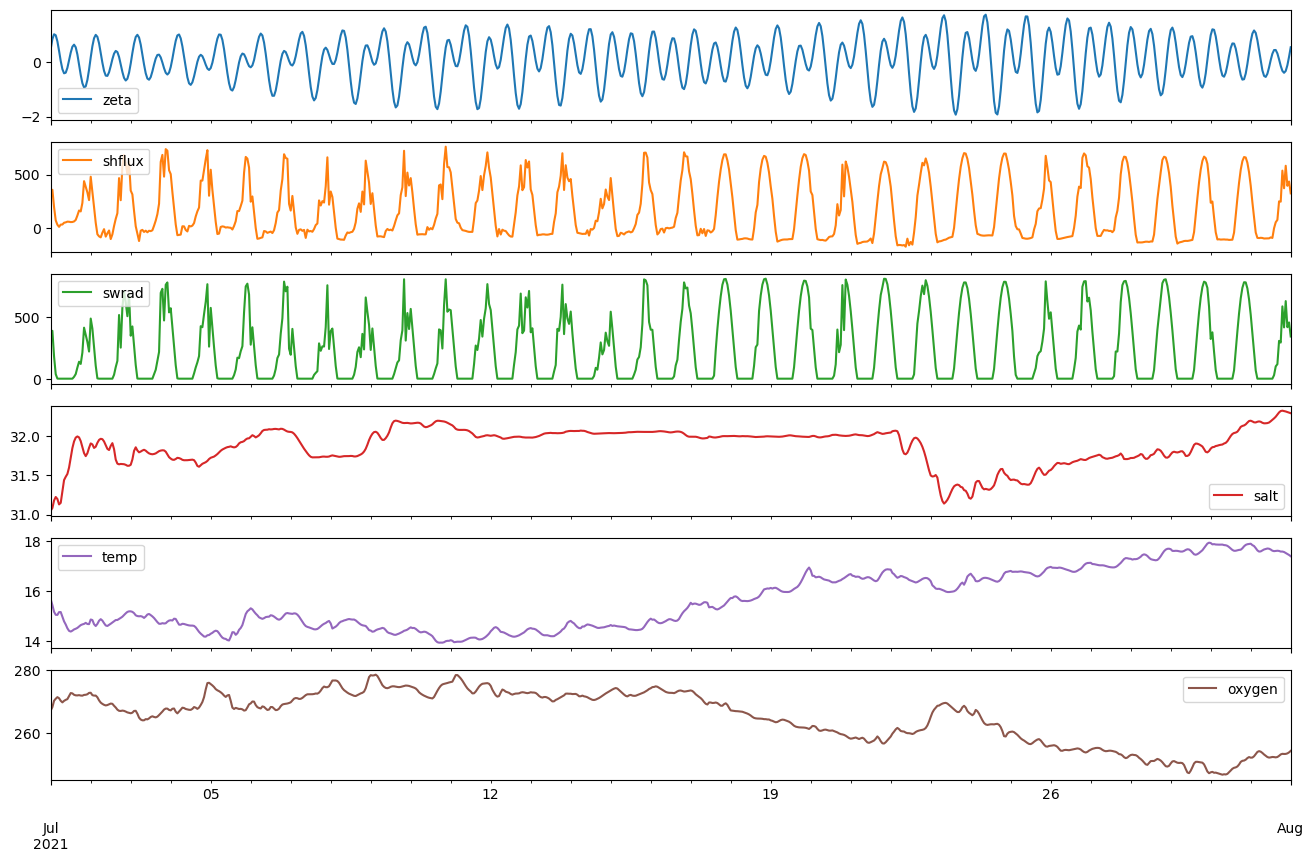

In [56]:
# Modified version of Parker's code; key features:
#   renamed Parker's T as 'Tpm' to avoid collisions

roms_datafile = '../data/roms_osb_july_2021.nc'
ds = xr.load_dataset(roms_datafile)
ot = ds.ocean_time.values
ot_dt = pd.to_datetime(ot)
t = (ot_dt - ot_dt[0]).total_seconds().to_numpy()
Tpm = t/86400 # time in days from start

print('time step of mooring'.center(60,'-'))
print(t[1])
print('time limits'.center(60,'-'))
print('start ' + str(ot_dt[0]))
print('end   ' + str(ot_dt[-1]))
print('info'.center(60,'-'))

VN_list = []
for vn in ds.data_vars:
    if not (vn == 'z_rho' or vn == 'z_w'):
        vnlj = vn.ljust(20, ' ')
        print('%s ( %s ) %s' % (vnlj, ds[vn].long_name, ds[vn].shape))
        VN_list.append(vn)
    
# populate lists of variables to plot
vn2_list = ['zeta']
if 'shflux' in VN_list:
    vn2_list += ['shflux', 'swrad']
vn3_list = []
if 'salt' in VN_list:
    vn3_list += ['salt', 'temp']
if 'oxygen' in VN_list:
    vn3_list += ['oxygen']

# plot time series using a pandas DataFrame
df = pd.DataFrame(index=ot)
for vn in vn2_list:
    df[vn] = ds[vn].values
for vn in vn3_list:
    # the -1 means surface values (order 0...-1 is from seafloor to surface)
    df[vn] = ds[vn][:, -1].values

plt.close('all')
df.plot(subplots=True, figsize=(16,10))
plt.show()

### Parker's chart code

Compressed a bit for space. Modified version is used above to produce those charts. 


```
"""
Stand-alone code to plot a user-specified mooring extraction.
"""
from pathlib import Path
moor_fn = Path('...etcetera....nc')
import xarray as xr, matplotlib.pyplot as plt, pandas as pd, numpy as np

# load everything using xarray
ds = xr.load_dataset(moor_fn)
ot = ds.ocean_time.values
ot_dt = pd.to_datetime(ot)
t = (ot_dt - ot_dt[0]).total_seconds().to_numpy()
T = t/86400 # time in days from start
print('time step of mooring'.center(60,'-'))
print(t[1])
print('time limits'.center(60,'-'))
print('start ' + str(ot_dt[0]))
print('end   ' + str(ot_dt[-1]))
print('info'.center(60,'-'))
VN_list = []
for vn in ds.data_vars:
    print('%s %s' % (vn, ds[vn].shape))
    VN_list.append(vn)
    
# populate lists of variables to plot
vn2_list = ['zeta']
if 'shflux' in VN_list:
    vn2_list += ['shflux', 'swrad']
vn3_list = []
if 'salt' in VN_list:
    vn3_list += ['salt', 'temp']
if 'oxygen' in VN_list:
    vn3_list += ['oxygen']

# plot time series using a pandas DataFrame
df = pd.DataFrame(index=ot)
for vn in vn2_list:
    df[vn] = ds[vn].values
for vn in vn3_list:
    # the -1 means surface values
    df[vn] = ds[vn][:, -1].values

plt.close('all')
df.plot(subplots=True, figsize=(16,10))
plt.show()
```